In [1]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from random import random, seed

import sklearn.linear_model as skl
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# 0. The data

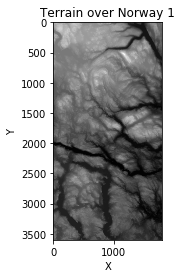

In [2]:
# Load the terrain
terrain1 = imread('SRTM_data_Norway_1.tif')
# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain1, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

The terrain data is the height, which is basically the z-function. X and Y are the points from 0-1801 and 0-3601 respectively. Making these vectors and then creating a meshgrid for x and y gives the points. 

In [3]:
x = np.arange(0, 1801)
y = np.arange(0, 3601)

xx, yy = np.meshgrid(x,y)

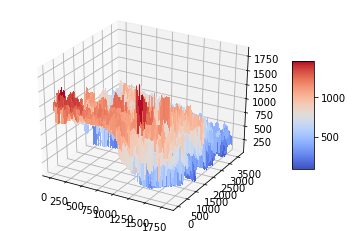

In [4]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(xx,yy,terrain1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [5]:
def CreateDesignMatrix_X(x, y, n = 5):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)
        
    N = len(x)
    l = int((n+1)*(n+2)/2)
    X = np.ones((N,l))
        
    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = x**(i-k) * y**k
    return X

In [6]:
terrain1 = (terrain1 - np.mean(terrain1)) / np.std(terrain1)

In [37]:
m = 7        # degree of polynomial

#Transform from matrices to vectors, reduce the data by taking every fourth point 
x_1 = np.ravel(xx)[::20]
y_1 = np.ravel(yy)[::20]
z_1 = np.ravel(terrain1)[::20]

# finally create the design matrix
X = CreateDesignMatrix_X(x_1, y_1, n=m)

z_1.shape

(324271,)

#### Simple regression to create a plot

In [38]:
beta1 = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(z_1)
ztilde1 = X @ beta1

In [39]:
"""
fig = plt.figure()
ax1 = fig.gca(projection='3d')

ax1.scatter(xx[::128], yy[::128], terrain1[::128], 
           alpha=0.5, 
           s=0.01, 
           color='black'
           )

ax1.plot_surface(xx[::128], yy[::128], ztilde.reshape(xx.shape), 
                alpha=0.4, 
                cmap=cm.coolwarm,
                )

plt.title(f'OLS regression fit')
plt.show()
"""

"\nfig = plt.figure()\nax1 = fig.gca(projection='3d')\n\nax1.scatter(xx[::128], yy[::128], terrain1[::128], \n           alpha=0.5, \n           s=0.01, \n           color='black'\n           )\n\nax1.plot_surface(xx[::128], yy[::128], ztilde.reshape(xx.shape), \n                alpha=0.4, \n                cmap=cm.coolwarm,\n                )\n\nplt.title(f'OLS regression fit')\nplt.show()\n"

# 1. OLS regression

Splitting the data into train and test data 

In [40]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ztrain, ztest = train_test_split(X, z_1, test_size=0.2)

Instead of 'inv' you could use 'pinv', which uses the SVD 'behind the scenes', if the matrix is not invertible it will use the SVD, if it is it will use normal inversion. However, here pinv gives really bad R2 scores, but it does make the MSE score much lower... 

In [41]:
beta = np.linalg.pinv(Xtrain.T.dot(Xtrain)).dot(Xtrain.T).dot(ztrain)
ztilde = Xtrain @ beta

zpred = Xtest @ beta

In [42]:
def MSE(z_data, z_model):
    n = np.size(z_model)
    return np.sum((z_data-z_model)**2)/n

print('MSE training:', MSE(ztrain, ztilde))
print('MSE test', MSE(ztest, zpred))

MSE training: 0.7622017503002688
MSE test 0.764226848123868


The MSE scores are crazy high because the data is not normalized. However, normalizing is not necessary for this project. 

In [43]:
def R2(z_data, z_model):
    return 1 - np.sum((z_data - z_model) ** 2) / np.sum((z_data - np.mean(z_model)) ** 2)

print('R2 training:', R2(ztrain, ztilde))
print('R2 test', R2(ztest, zpred))

R2 training: 0.27329807051164734
R2 test 0.27218502647787646


### 1.1. K-Fold cross-validation for OLS

In [44]:
# Initialize a KFold instance
k = 10

def cross_validation(x, y, k):
    n = len(x)
    
    indexes = np.arange(y.shape[0])
    np.random.shuffle(indexes)
    x = x[indexes]
    y = y[indexes]
    
    r2_test = []
    mse_test = []
    for i in range(k):
        x_train = np.concatenate((x[:int(i*n/k)], x[int((i + 1)*n/k): ]), axis = 0)
        x_test = x[int(i*n/k):int((i + 1)*n/k)]
        y_train = np.concatenate((y[:int(i*n/k)], y[int((i + 1)*n/k): ]), axis = 0)
        y_test = y[int(i*n/k):int((i + 1)*n/k)]

        beta = np.linalg.pinv(x_train.T.dot(x_train)).dot(x_train.T).dot(y_train)
        ytilde = x_train @ beta
        ypredict = x_test @ beta
        
        mse_test.append(MSE(y_test, ypredict))
        r2_test.append(R2(y_test, ypredict))
    
    r2_test = np.array(r2_test)
    mse_test = np.array(mse_test)
    print("R2-Score_OLS: %0.3f (+/- %0.3f)" % (r2_test.mean(), r2_test.std() * 2))
    print("MSE-Score_OLS: %0.5f (+/- %0.5f)" % (mse_test.mean(), mse_test.std() * 2))
        
    return r2_test, mse_test

In [45]:
r, m = cross_validation(X, z_1, k)

R2-Score_OLS: 0.272 (+/- 0.006)
MSE-Score_OLS: 0.76336 (+/- 0.01326)


And using sklearn:

In [46]:
linreg = skl.LinearRegression()
linreg.fit(Xtrain, ztrain)

ztilde2 = linreg.predict(Xtest)

In [47]:
kfold = KFold(n_splits = k, shuffle=True)

scores_test = cross_val_score(linreg, Xtest, ztest, cv = kfold)
print("R2-Score sk_OLS: %0.2f (+/- %0.2f)" % (scores_test.mean(), scores_test.std() * 2))

scores_mse_test = cross_val_score(linreg, Xtest, ztest, scoring='neg_mean_squared_error', cv=kfold)
estimated_mse_test = np.mean(-scores_mse_test)
print('MSE-score sk_OLS:', estimated_mse_test)

R2-Score sk_OLS: 0.54 (+/- 0.02)
MSE-score sk_OLS: 0.46571505052689605


The results are almost the same, which means that our code gives the same result as using sklearn

### Complexity of the model vs. the MSE score

/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


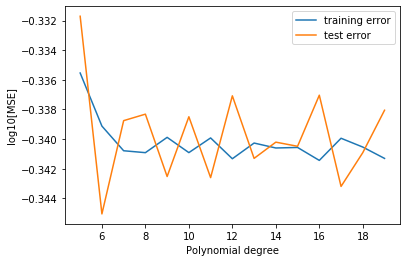

In [49]:
maxdegree = 20
train_mse = np.zeros(maxdegree)
test_mse = np.zeros(maxdegree)

polynomial = np.zeros(maxdegree)

for degree in range(5, maxdegree):
    X1 = CreateDesignMatrix_X(x_1, y_1, n=degree)

    X1_train, X1_test, z1_train, z1_test = train_test_split(X1, z_1, test_size=0.2)
    beta2 = np.linalg.inv(X1_train.T.dot(X1_train)).dot(X1_train.T).dot(z1_train)
    ztilde1 = X1_train @ beta2
    zpredict1 = X1_test @ beta2
    
    polynomial[degree] = degree
    test_mse[degree] = MSE(z1_test, zpredict1)
    train_mse[degree] = MSE(z1_train, ztilde1)

plt.plot(polynomial, np.log10(train_mse), label='training error')
plt.plot(polynomial, np.log10(test_mse), label='test error')

plt.xlabel('Polynomial degree')
plt.ylabel('log10[MSE]')
plt.legend()
plt.show()

# 2. Ridge regression

Let's first see which lambda is best, so that we know which value of lambda to use for the ridge regression

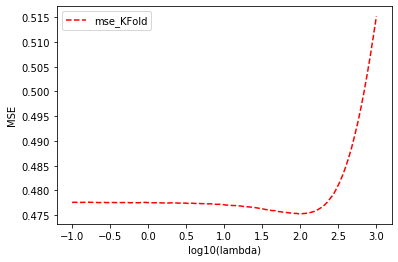

In [50]:
nlambdas = 100
lambdas = np.logspace(-1, 3, nlambdas)

k = 10
kfold = KFold(n_splits = k, shuffle=True)

mse_scores_KFold = np.zeros((nlambdas, k))
r2_scores_KFold = np.zeros((nlambdas, k))

i = 0
for lmb in lambdas:
    betaridge1 = np.linalg.inv(Xtrain.T.dot(Xtrain)+(lmb*np.eye(len(Xtrain[0])))).dot(Xtrain.T).dot(ztrain)
    j = 0
    for train_inds, test_inds in kfold.split(x):
        Xtrain_r = [train_inds]
        ztrain_r = z_1[train_inds]

        Xtest_r = X[test_inds]
        ztest_r = z_1[test_inds]
        
        zpred_r = Xtest_r @ betaridge1

        mse_scores_KFold[i,j] = np.sum((zpred_r - ztest_r)**2)/np.size(zpred_r)

        j += 1
    i += 1

estimated_mse_KFold = np.mean(mse_scores_KFold, axis = 1)
#estimated_r2_KFold = np.mean(r2_scores_KFold, axis = 1)

plt.figure()

plt.plot(np.log10(lambdas), estimated_mse_KFold, 'r--', label = 'mse_KFold')

plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [51]:
_lambda = 10**2

X_train_r, X_test_r = Xtrain, Xtest

betaridge = np.linalg.inv(X_train_r.T.dot(X_train_r)+(_lambda*np.eye(len(X_train_r[0])))).dot(X_train_r.T).dot(ztrain)
zridge = X_train_r @ betaridge

ridge_predict = X_test_r @ betaridge

print("MSE OLS:", np.mean(m))
print("MSE-score Ridge:", MSE(ztest, ridge_predict))

print("R2-score OLS:", np.mean(r))
print("R2-score Ridge", R2(ztest, ridge_predict))

MSE OLS: 0.7633611513441755
MSE-score Ridge: 0.45582977383857454
R2-score OLS: 0.2722656292049148
R2-score Ridge 0.5441719784261662


In [24]:
param_grid = {'alpha': lambdas}

nlambdas = 100
lambdas = np.logspace(20, 40, nlambdas)

ridge = Ridge(tol = 100, max_iter = 10e5)

ridge_regressor = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=kfold)
ridge_regressor.fit(X[:,1:], z_1)

print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42875e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42089e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42134e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43072e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43343e-33): result may not be accurate.
  overwrite_a=True).T


/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42134e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43072e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43343e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42677e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43235e-33): result may not be accurate.
  overwrite_a=True).T


/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43343e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42677e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43235e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.41984e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42136e-33): result may not be accurate.
  overwrite_a=True).T


/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43235e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.41984e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42136e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43761e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42875e-33): result may not be accurate.
  overwrite_a=True).T


/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42136e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43761e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42875e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42089e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42134e-33): result may not be accurate.
  overwrite_a=True).T


/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42875e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42089e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42134e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43072e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43343e-33): result may not be accurate.
  overwrite_a=True).T


/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42134e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43072e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43343e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42677e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43235e-33): result may not be accurate.
  overwrite_a=True).T


/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43072e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43343e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42677e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43235e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.41984e-33): result may not be accurate.
  overwrite_a=True).T


/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43235e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.41984e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42136e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43761e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42875e-33): result may not be accurate.
  overwrite_a=True).T


/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42136e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43761e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42875e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42089e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42134e-33): result may not be accurate.
  overwrite_a=True).T


/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42875e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42089e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42134e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43072e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43343e-33): result may not be accurate.
  overwrite_a=True).T


/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42134e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43072e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43343e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42677e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43235e-33): result may not be accurate.
  overwrite_a=True).T


/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43343e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42677e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43235e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.41984e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42136e-33): result may not be accurate.
  overwrite_a=True).T


/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43235e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.41984e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42136e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43761e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42875e-33): result may not be accurate.
  overwrite_a=True).T


/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42136e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43761e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42876e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.4209e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42134e-33): result may not be accurate.
  overwrite_a=True).T
/

/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42876e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.4209e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42134e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43072e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43344e-33): result may not be accurate.
  overwrite_a=True).T
/

/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42134e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43073e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43344e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42677e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43236e-33): result may not be accurate.
  overwrite_a=True).T


/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43344e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42678e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43236e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.41985e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42136e-33): result may not be accurate.
  overwrite_a=True).T


/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43236e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.41985e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42137e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43762e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42876e-33): result may not be accurate.
  overwrite_a=True).T


/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42137e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43763e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42877e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42091e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42136e-33): result may not be accurate.
  overwrite_a=True).T


/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42878e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42092e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42136e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43075e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43346e-33): result may not be accurate.
  overwrite_a=True).T


/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42137e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43076e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43347e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.4268e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43239e-33): result may not be accurate.
  overwrite_a=True).T
/

/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43348e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42682e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.4324e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.41989e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42141e-33): result may not be accurate.
  overwrite_a=True).T
/

/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43242e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.41992e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42143e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43768e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42883e-33): result may not be accurate.
  overwrite_a=True).T


{'alpha': 1000.0}
-0.46268048282868574


/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43771e-33): result may not be accurate.
  overwrite_a=True).T
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.42744e-33): result may not be accurate.
  overwrite_a=True).T


In [29]:
_lambda = 100

ridge = Ridge(alpha = _lambda, tol = 100, max_iter = 10e5).fit(Xtrain[:,1:], ztrain)
pred_ridge = ridge.predict(Xtest[:,1:])

#estimated_mse_folds = cross_val_score(ridge, X, z_1, scoring='neg_mean_squared_error', cv=kfold)

/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.41966e-33): result may not be accurate.
  overwrite_a=True).T


In [63]:
print('MSE OLS:', np.mean(m))
print('MSE ridge:', MSE(ztest, pred_ridge))

print('R2 OLS:', R2(ztest, zpred))
print('R2 ridge:', R2(ztest, pred_ridge))

MSE OLS: 0.7488406919450591
MSE ridge: 0.5801711879888233
R2 OLS: 0.2815755878936177
R2 ridge: 0.4211225486351543


In [31]:
def cross_validation_ridge(x, y, lmb, k):
    n = len(x)
    
    indexes = np.arange(y.shape[0])
    np.random.shuffle(indexes)
    x = x[indexes]
    y = y[indexes]
    
    r2_test = []
    mse_train = []
    mse_test = []
    
    bias = []
    variance = []
    for i in range(k):
        x_train = np.concatenate((x[:int(i*n/k)], x[int((i + 1)*n/k): ]), axis = 0)
        x_test = x[int(i*n/k):int((i + 1)*n/k)]
        y_train = np.concatenate((y[:int(i*n/k)], y[int((i + 1)*n/k): ]), axis = 0)
        y_test = y[int(i*n/k):int((i + 1)*n/k)]

        beta = np.linalg.inv(x_train.T.dot(x_train)+(lmb*np.eye(len(x_train[0])))).dot(x_train.T).dot(y_train)

        ytilde = x_train @ beta
        ypredict = x_test @ beta
        
        mse_train.append(MSE(y_train, ytilde))
        mse_test.append(MSE(y_test, ypredict))
        r2_test.append(R2(y_test, ypredict))
        
        bias.append(np.mean((y_test - np.mean(ypredict))**2))
        variance.append(np.mean(np.var(ypredict)))
    
    r2_test = np.array(r2_test)
    mse_train = np.array(mse_train)
    mse_test = np.array(mse_test)
    
    bias = np.array(bias)
    variance = np.array(variance)
        
    return r2_test, mse_train, mse_test, bias, variance

/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


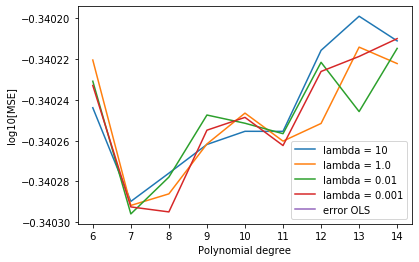

In [36]:
maxdegree = 15
polynomial = np.arange(maxdegree)

_lambdas = [10, 1.0, 0.01, 0.001]

CV_mse_ridge = np.zeros((maxdegree, len(_lambdas)))
#CV_mse_OLS = np.zeros(maxdegree)

for degree in range(6, maxdegree):
    XR = CreateDesignMatrix_X(x_1, y_1, n=degree)  
    #CV_mse_OLS[degree] = np.mean(cross_validation(X_new, z_1, k)[2])

    XR_train, XR_test, zR_train, zR_test = train_test_split(XR, z_1, test_size=0.2)
    
    #true_mse_ridge = []
    for i in range(len(_lambdas)):       
        CV_mse_ridge[degree, i] = np.mean(cross_validation_ridge(XR, z_1, _lambdas[i], k)[2])

for i in range(len(_lambdas)):
    plt.plot(polynomial, np.log10(CV_mse_ridge[:,i]), label='lambda = {}'.format(_lambdas[i]))

plt.plot(polynomial, np.log10(CV_mse_OLS), label='error OLS')    #the matrix probably gets near-singular for a higher complexity, which is why the OLS error goes up real fast. we can try the SVD
plt.xlabel('Polynomial degree')
plt.ylabel('log10[MSE]')
#plt.title('Ridge regression')
plt.legend()
plt.show()   

# 3. Lasso regression

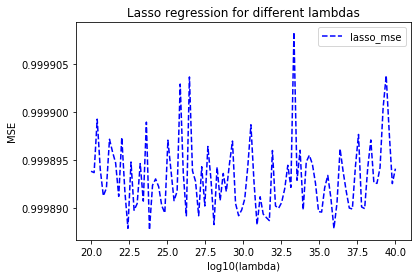

In [30]:
lasso_mse = np.zeros(nlambdas)

i = 0
for lmb in lambdas:
    lasso = skl.Lasso(alpha = lmb, precompute = True, tol = 10, max_iter = 10e3)

    lasso_mse_folds = cross_val_score(lasso, X[:,1:], z_1, scoring='neg_mean_squared_error', cv=kfold)
    lasso_mse[i] = np.mean(-lasso_mse_folds)
    i += 1

plt.figure()
plt.plot(np.log10(lambdas), lasso_mse, 'b--', label = 'lasso_mse')
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.title('Lasso regression for different lambdas')
plt.legend()
plt.show()

/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


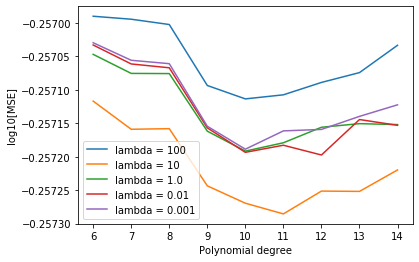

In [55]:
maxdegree = 15
polynomial = np.arange(maxdegree)

_lambdas = [100, 10, 1.0, 0.01, 0.001]

CV_mse_lasso = np.zeros((maxdegree, len(_lambdas)))
#CV_mse_OLS = np.zeros(maxdegree)

for degree in range(6, maxdegree):
    XR = CreateDesignMatrix_X(x_1, y_1, n=degree)  
    #CV_mse_OLS[degree] = np.mean(cross_validation(X_new, z_1, k)[2])
    
    #true_mse_ridge = []
    for i in range(len(_lambdas)):
        lasso = skl.Lasso(alpha = _lambdas[i], precompute = True, tol = 10, max_iter = 10e3)
        
        lasso_mse_folds = cross_val_score(lasso, XR[:,1:], z_1, scoring='neg_mean_squared_error', cv=kfold)
        
        CV_mse_lasso[degree, i] = np.mean(-lasso_mse_folds)
    
for i in range(len(_lambdas)):
    plt.plot(polynomial, np.log10(CV_mse_lasso[:,i]), label='lambda = {}'.format(_lambdas[i]))

#plt.plot(polynomial, np.log10(CV_mse_OLS), label='error OLS')    #the matrix probably gets near-singular for a higher complexity, which is why the OLS error goes up real fast. we can try the SVD
plt.xlabel('Polynomial degree')
plt.ylabel('log10[MSE]')
#plt.title('Ridge regression')
plt.legend()
plt.show()   

In [58]:
nlambdas = 100
lambdas_lasso = np.logspace(-10, -3, nlambdas)
param_grid_lasso = {'alpha': lambdas_lasso}

lasso = skl.Lasso(precompute = True, tol = 100, max_iter = 10e3)

lasso_regressor = GridSearchCV(lasso, param_grid_lasso, scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(X, z_1)

print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

{'alpha': 1e-05}
-58550.03750290805


In [89]:
m = 11        # degree of polynomial

#Transform from matrices to vectors, reduce the data by taking every fourth point 
x_1 = np.ravel(xx)[::20]
y_1 = np.ravel(yy)[::20]
z_1 = np.ravel(terrain1)[::20]

# finally create the design matrix
X_lasso = CreateDesignMatrix_X(x_1, y_1, n=m)

Xtrain_lasso, Xtest_lasso, ztrain_lasso, ztest_lasso = train_test_split(X_lasso, z_1, test_size=0.2)

In [90]:
l_lambda = 10

clf_lasso = skl.Lasso(alpha=l_lambda, precompute = True, tol = 10, max_iter = 10e3).fit(Xtrain, ztrain)
pred_lasso = clf_lasso.predict(Xtest)

In [91]:
print("MSE lasso:", MSE(ztest, pred_lasso))
print("R2 lasso:", R2(ztest, pred_lasso))

MSE lasso: 0.5514655899390856
R2 lasso: 0.448535948285516


In [92]:
clf_lasso = skl.Lasso(alpha=l_lambda, precompute = True, tol = 10, max_iter = 10e3).fit(Xtrain_lasso, ztrain_lasso)
pred_lasso = clf_lasso.predict(Xtest_lasso)

In [93]:
print("MSE lasso:", MSE(ztest, pred_lasso))
print("R2 lasso:", R2(ztest, pred_lasso))

MSE lasso: 1.3684134914123978
R2 lasso: -0.3683657550009347
